In [1]:
import warnings; warnings.filterwarnings('ignore')

In [2]:
from facets import facets
import numpy as np
import glob
import pandas as pd
import xarray as xr
import salem
import geopandas as gpd
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [3]:
def lsqfity(X, Y):
    X, Y = map(np.asanyarray, (X, Y))

    # Determine the size of the vector.
    n = len(X)
    
    # Calculate the sums.

    Sx = np.sum(X)
    Sy = np.sum(Y)
    Sx2 = np.sum(X ** 2)
    Sxy = np.sum(X * Y)
    Sy2 = np.sum(Y ** 2)

    # Calculate re-used expressions.
    num = n * Sxy - Sx * Sy
    den = n * Sx2 - Sx ** 2

    # Calculate my, by, ry, s2, smy and sby.
    my = num / den
    by = (Sx2 * Sy - Sx * Sxy) / den
    ry = num / (np.sqrt(den) * np.sqrt(n * Sy2 - Sy ** 2))

    diff = Y - by - my * X

    s2 = np.sum(diff * diff) / (n - 2)
    smy = np.sqrt(n * s2 / den)
    sby = np.sqrt(Sx2 * s2 / den)

    return my, by, ry, smy, sby

def drift_data(data):
    idx = np.arange(len(data.Date))
    drft, drft_intcept, drft_r, drft_std_err, drft_intcept_std_err = lsqfity(idx, data)
    df = pd.DataFrame(index = data.Date)
    df['trend'] = drft*idx+drft_intcept
    return df,drft
    
def region_stat(data, shp, region, method = np.mean):
    shape = shp[shp.Region == region]
    ds = data.salem.roi(shape = shape).apply(method, axis = (1,2))
    return ds

def gen_fig(nrows,ncols,width=None,aspect=None,pad=None,kw=None,grid=None):
    if not width:
        width=10
    if not aspect:
        aspect=0.5
    if not pad:
        pad=dict(wspace=0, hspace=0, left=0.06, bottom=0.06, right=0.98, top=0.95)
    if not kw:
        kw=dict(sharey='row', sharex='col')
    fig, axes = plt.subplots(nrows,ncols,figsize=(width,width*aspect),gridspec_kw=grid, **kw)
    fig.subplots_adjust(**pad)
    return fig, axes

def multi_plot(ds, shp, method = np.mean, yleb = 'Minimum Temperature'):
    fig, axes = gen_fig(4,2, width = 12, aspect = 0.6)
    axes = axes.flatten() 
    axes[1].axis('off')
    axs = np.delete(axes,[1])
    for region, ax, label in zip(reg, axs, labels):
        region_stat(ds, shp, region, method = method).plot(ax = ax)  
        ax.set_title(y = 0.83, label = label)
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        ax.set_ylim([-8,39])
    axs[-2].set_xlabel('Date', position=(1,0), fontsize = 20)
    axs[3].set_ylabel(yleb, position=(0,1), fontsize = 20)
    return fig, axes

def all_in_one(ds, shp, ylim = [-8,49], fnt = 14, yleb = 'Temperature [\u00B0C]'):
    xtex = '01-01-1985'
    ytex = ylim[1]+5
    #fig, axes = facets(1, 1, width=16.0, aspect=0.8, internal_pad=0.0, top_pad=.5,
     #            bottom_pad=0.6, left_pad=0.2, right_pad=0.1)
    fig, axes = gen_fig(7,3, width = 16, aspect = 0.8)
    for i, (region, label) in enumerate(zip(reg, labels)):
        region_stat(ds[0], shp, region, method = np.mean).plot(ax = axes[i,0])  
        region_stat(ds[1], shp, region, method = np.max).plot(ax = axes[i,1])
        region_stat(ds[2], shp, region, method = np.min).plot(ax = axes[i,2])
        axes[i,0].set_title(y = 0.81, label = label)
        
    for ax in axes.flatten():
        ax.minorticks_on()
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        ax.set_ylim(ylim)
        
#     year = ['','1970','','1978','','1986','','1994','','2002']
#     for ax in axes[-1,:]:
#         ax.set_xticklabels(year, fontsize = fnt, rotation = 0)
        
    axes[-1,1].set_xlabel('Date', position=(0.5,0), fontsize = fnt+5)
    axes[-3,0].set_ylabel(yleb, position=(0,1), fontsize = fnt+5)
    
    axes[0,0].text(xtex, ytex, 'Mean', fontsize = fnt)
    axes[0,1].text(xtex, ytex, 'Maximum', fontsize = fnt)
    axes[0,2].text(xtex, ytex, 'Minimum', fontsize = fnt)
    return fig, axes



def select_season(ds, months):
    data =  ds.sel(time = np.in1d(ds['time.month'], months))
    data1 = data.resample('A', dim='time', how = 'mean')
    data2 = data.resample('A', dim='time', how = 'max')
    data3 = data.resample('A', dim='time', how = 'min')
    return [data1, data2, data3]

def get_map(data, shp, ax):
    smap = data.salem.get_map(data = data, countries = False)
    smap.set_shapefile(shape = shp, color='black', linewidth = 2)
    c = smap.visualize(ax = ax)
    return c, ax 

In [4]:
fpath = '/home/pankaj/phd/practice/vishal/data/'
ppath = '/home/pankaj/phd/practice/vishal/plots/'

In [5]:
reg = ['PI', 'WC', 'NE', 'cne', 'nw', 'HillyKash', 'HillyHimachal']
labels = ['Peninsular India', 'West Central', 'North East', 'Central North East', 'North West', 'HillyKash', 'HillyHimachal']

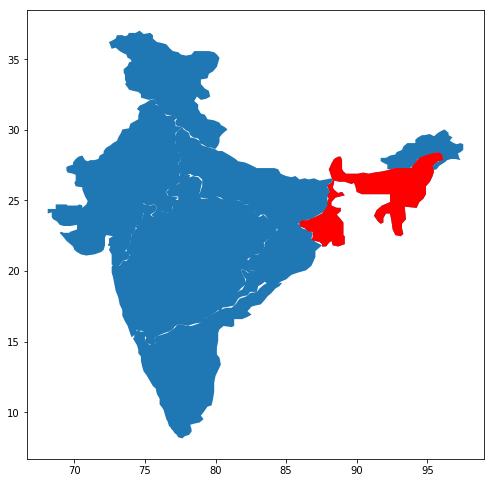

In [6]:
shp = gpd.read_file(fpath + 'homogenous/india.shp')
data1 = xr.open_mfdataset(fpath + 'rf*.nc').sel(lat = slice(6.5,38.5),lon = slice(66.5,100))
data2 = xr.open_mfdataset(fpath + 'srf2017.nc').sel(lat = slice(6.5,38.5),lon = slice(66.5,100))
data = xr.concat([data1,data2], dim='time')
ds = data.salem.roi(shape = shp)
ds = ds.sortby('time')

fig, axes = gen_fig(1,1, width = 10, aspect = 0.7)
shp.plot(ax=axes); shp[shp.Region == 'NE'].plot(ax=axes, color = 'red')
fig.savefig(ppath + 'North East.png')

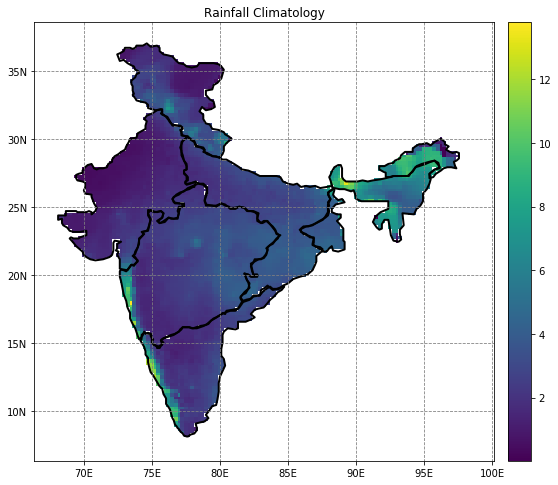

In [7]:
# climatology
fig, ax = facets(1, 1, width=9.0, aspect=0.7, internal_pad=0.0, top_pad=.5,
                 bottom_pad=0.6, left_pad=0.2, right_pad=0.1)
smap = ds.salem.get_map(data = ds.mean(dim = 'time')['rf'], countries =False)
smap.set_shapefile(shape = shp, color='black', linewidth = 2)
smap.visualize(ax = ax[0], title = 'Rainfall Climatology')
fig.get_tight_layout()
fig.savefig(ppath + 'climatology.png')

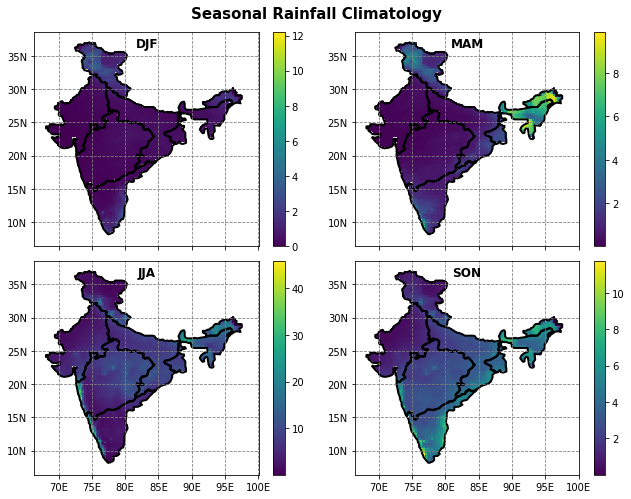

In [8]:
# seasonal climatology
fig, axes = facets(2, 2, width=9.0, aspect=0.7, sharey = False, internal_pad=0.2, top_pad=.5,
                 bottom_pad=0.6, left_pad=0.2, right_pad=0.1)
data = ds.groupby('time.season').mean('time')['rf']
for ax, season in zip(axes, ['DJF','MAM','JJA','SON']):
    c, ax = get_map(data.sel(season = season), shp, ax)
    ax.set_title(season, fontweight = 'bold', y = 0.9)
plt.suptitle('Seasonal Rainfall Climatology', fontweight = 'bold', fontsize = 15)
fig.savefig(ppath + 'Rainfall Seasonal climatology1.png')

In [ ]:
# seasonal climatology
fig, axes = facets(2, 2, width=9.0, aspect=0.7, sharey = False, internal_pad=0.8, top_pad=.5,
                 bottom_pad=0.6, left_pad=0.4, right_pad=0.1)
data = ds.groupby('time.season').mean('time')['rf']
lon, lat = np.meshgrid(data.lon, data.lat)
levels=np.arange(-10, 40, 1)
for ax, season in zip(axes, ['DJF','MAM','JJA','SON']):
    h = ax.contourf(lon, lat, data.sel(season = season), levels=levels, vmin=levels.min(), vmax=levels.max())
    ax.set_title(season, fontweight = 'bold', y = 0.9)
    for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        #l.set_weight("bold")
        l.set_fontsize(14)
cax, kw = mpl.colorbar.make_axes([ax for ax in axes])
cb = plt.colorbar(h, cax = cax, **kw)
cb.ax.tick_params(labelsize=13)
cb.ax.get_yaxis().labelpad = 25
cb.ax.set_ylabel('Rainfall', rotation=270,fontsize=16)
plt.suptitle('Seasonal Rainfall Climatology', fontweight = 'bold', fontsize = 15)
fig.savefig(ppath + 'Rainfall Seasonal climatology2.png')

Text(0,1,'Seasonal (DJF) Rainfall')

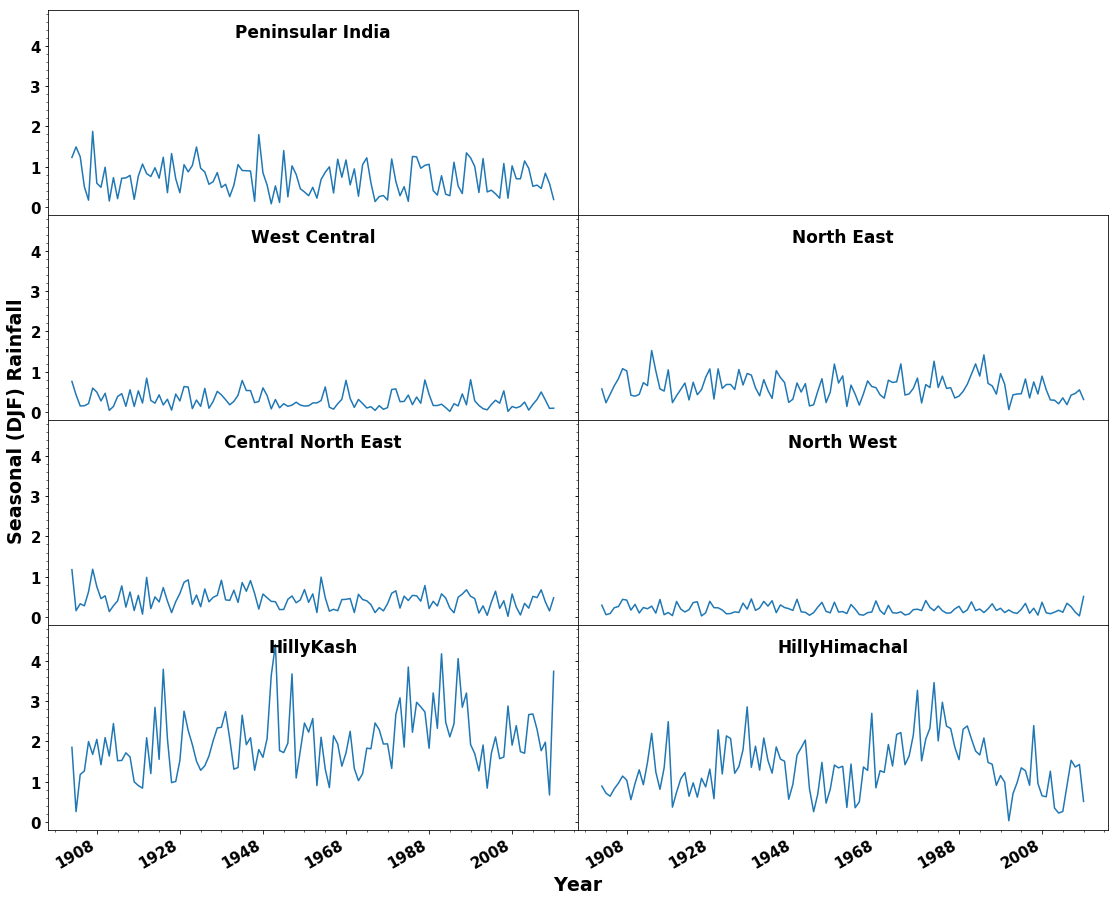

In [10]:
# DJF data
fnt = 14
ylim = [-0.2, 4.9]
yleb = 'Seasonal (DJF) Rainfall'
data =  ds.sel(time = np.in1d(ds['time.month'], [12,1,2])).resample('A', dim='time', how = 'mean')#['rf']
fig, axes = gen_fig(4,2, width = 16, aspect = 0.8)
axes = axes.flatten(); axes[1].axis('off'); axes = np.delete(axes,[1])
for i, (ax, region, label) in enumerate(zip(axes, reg, labels)):
        region_stat(data, shp, region, method = np.mean)['rf'].plot(ax = ax)  
        ax.set_title(y = 0.84, label = label, fontsize = fnt+3, fontweight = 'bold')
        ax.minorticks_on()
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        ax.set_ylim(ylim)
        for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
            l.set_weight("bold")
            l.set_fontsize(fnt+1)
axes[-2].set_xlabel('Year', position=(1.0,0), fontsize = fnt+5, fontweight = 'bold')
axes[-4].set_ylabel(yleb, position=(0,1), fontsize = fnt+5, fontweight = 'bold')
#fig, axes = all_in_one(select_season(ds, months = [12,1,2]), shp, yleb = 'Seasonal (DJF) Temperature [\u00B0C]')
#fig.savefig(ppath + 'DJF trend.png')